## Simple CSV Generation with Generation Counts

This section creates CSV files similar to the langfuse_export section 3, but adds a column for the number of generation attempts used for each trace.

In [76]:
import traceback
import pandas as pd
import json
import os
from datetime import datetime
from dateutil import parser

# Setup paths - same as langfuse_export
parent_dir = os.path.dirname(os.getcwd())
raw_export_dir = os.path.join(parent_dir, "raw_export")
processed_data_dir = os.path.join(parent_dir, "processed_data")


# Get session id list from data directory
session_id_list = []

for root, dirs, files in os.walk(raw_export_dir):
    for file in files:
        file_path = os.path.join(root, file)
        if "trimmed_" in file_path:
            session_id = file_path.split('trimmed_')[1].rstrip('.json')
            session_id_list.append(session_id)

print(f"Processing sessions: {session_id_list}")
print(f"Looking for raw files in: {raw_export_dir}")
print(f"Will save CSV files to: {processed_data_dir}")


def json_to_csv_weighted(session_id):
    """
    Convert JSON trace data to CSV format with aggregated metrics.
    Upgraded version that includes generation_count column.

    Args:
        session_id (str): Identifier for the session to process
    """

    def extract_observation_details(observations, trace_id):
        """Extract and aggregate metrics from observations"""
        metrics = {
            "status": None,
            "latency": 0,
            "total_tokens": 0,
            "prompt_tokens": 0,
            "completion_tokens": 0,
            "total_cost": 0,
            "input_cost": 0,
            "output_cost": 0,
            "parameters": set(),
            "generation_count": 0,  # New field for generation count
        }

        # Count generations and process GENERATION observations
        for obs in (o for o in observations if o["type"] == "GENERATION"):
            metrics["generation_count"] += 1
            metrics["total_tokens"] += obs["totalTokens"]
            metrics["prompt_tokens"] += obs["promptTokens"]
            metrics["completion_tokens"] += obs["completionTokens"]
            metrics["latency"] += obs["latency"]
            for key, value in obs["modelParameters"].items():
                metrics["parameters"].add(key + ":" + value)

            # Add costs if present
            for cost_type in ["Total", "Input", "Output"]:
                key = f"calculated{cost_type}Cost"
                metric_key = cost_type.lower() + "_cost"
                if obs.get(key) is not None:
                    metrics[metric_key] += obs[key]
                    
        if len(metrics["parameters"]) == 0:
            metrics["parameters"] = "N/A"
            
        # Process SPAN observations for status
        status_indicators = [
            obs["name"]
            for obs in observations
            if obs["type"] == "SPAN" and "start_" not in obs["name"]
        ]

        #  if later than 2025-05-19, use status_signal_from_output
        if datetime.now() > datetime(2025, 5, 19):
            pass
        else:
            # Determine status
            success_signals = sum("end_" in name for name in status_indicators)
            failure_signals = sum(
                "failure_signal" in name for name in status_indicators
            )

            if success_signals + failure_signals > 1:
                raise ValueError(
                    f"Multiple status indicators found in trace {trace_id}"
                )

            metrics["status"] = (
                "success"
                if success_signals
                else "failure" if failure_signals else "unknown"
            )

        metrics["prompt_cost"] = metrics.pop("input_cost")
        metrics["completion_cost"] = metrics.pop("output_cost")
        metrics["latency"] = round(metrics["latency"] / 1000, 2)
        return metrics

    def cal_time(trace):
        time_diff = datetime.fromisoformat(
            trace["updatedAt"].replace("Z", "+00:00")
        ) - datetime.fromisoformat(trace["createdAt"].replace("Z", "+00:00"))
        seconds_diff = time_diff.total_seconds()
        return seconds_diff

    try:
        if session_id.startswith("da0a"):
            session_id = "phi4_" + session_id
        simple_session_id = session_id.rsplit("_", 2)[0]

        # Load JSON data
        if "tpsg" in session_id:
            session_id_ = session_id.replace("tpsg", "tpusg")
        else:
            session_id_ = session_id
        trimmed_path = os.path.join(raw_export_dir, f"trimmed_{session_id_}.json")
        print(
            f"Processing session {session_id}, simple id {simple_session_id}. Look for {trimmed_path}"
        )
        with open(trimmed_path, "r") as file:
            traces = json.load(file)["data"]

        # Process traces
        rows = [
            {
                "num_run": trace["metadata"]["num_run"],
                "name": trace["name"],
                "trace_id": trace["id"],
                "batch_id": trace["session_id"],
                # "latency": cal_time(trace),
                # "latency": round(trace["latency"], 2),
                **extract_observation_details(
                    trace["observations"],
                    trace["id"],
                ),
                "status": (
                    "failure"
                    if trace["output"]["status"].lower() == "failed"
                    else "success"
                ),
                "tags": trace["tags"],
                "timestamp": int(parser.isoparse(trace["timestamp"]).timestamp()),
            }
            for trace in traces
        ]
        
        # Create and save DataFrame
        df = pd.DataFrame(rows).sort_values("num_run")

        output_dir = os.path.join(processed_data_dir, f"{simple_session_id}")
        if not os.path.exists(output_dir):
            os.makedirs(output_dir, exist_ok=True)

        output_path = os.path.join(output_dir, f"clean_{session_id_}.csv")

        print(output_path)
        df.to_csv(output_path, index=False)
        print(f"Successfully saved CSV to: {output_path}")

    except FileNotFoundError as e:
        print(
            f"FileNotFoundError: For session {session_id} not found. Looked for {trimmed_path}\nError info: \n{e}\n\nTraceback: {traceback.format_exc()}"
        )
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON format in input file for session {session_id}")
    except Exception as e:
        print(f"Error processing session {session_id}: {str(e)}")



# Example usage
for session_id in session_id_list:
    json_to_csv_weighted(session_id)

Processing sessions: ['gemma3:27b_d558_psg_batch', 'gemma3:27b_b603_tpusg_batch']
Looking for raw files in: /Users/hann/Projects/reference-benchmark-tinyml_llm/data_analysis/2025/08.12/raw_export
Will save CSV files to: /Users/hann/Projects/reference-benchmark-tinyml_llm/data_analysis/2025/08.12/processed_data
Processing session gemma3:27b_d558_psg_batch, simple id gemma3:27b_d558. Look for /Users/hann/Projects/reference-benchmark-tinyml_llm/data_analysis/2025/08.12/raw_export/trimmed_gemma3:27b_d558_psg_batch.json
/Users/hann/Projects/reference-benchmark-tinyml_llm/data_analysis/2025/08.12/processed_data/gemma3:27b_d558/clean_gemma3:27b_d558_psg_batch.csv
Successfully saved CSV to: /Users/hann/Projects/reference-benchmark-tinyml_llm/data_analysis/2025/08.12/processed_data/gemma3:27b_d558/clean_gemma3:27b_d558_psg_batch.csv
Processing session gemma3:27b_b603_tpusg_batch, simple id gemma3:27b_b603. Look for /Users/hann/Projects/reference-benchmark-tinyml_llm/data_analysis/2025/08.12/raw

## Weighted Success Rate Analysis

Now let's analyze the data to compare traditional success rates vs generation-weighted success rates between PSG and TPUSG approaches.

In [77]:
# Load and analyze the generated CSV files
import glob
import numpy as np


STAGE_ORDER = [
    "Data Processor",
    "Model Converter",
    "Sketch Generator",
    "PySketch Generator",
    "TPUSketch Generator",
]
STAGE_ABBR = {
    "Data Processor": "DP",
    "Model Converter": "MC",
    "Sketch Generator": "SG",
    "PySketch Generator": "PSG",
    "TPUSketch Generator": "TPUSG",
}
# Dfined for plottings
TASK_COLORS = {
    "Model Converter": "blue",
    "Data Processor": "green",
    "Sketch Generator": "purple",
    "PySketch Generator": "red",
    "TPUSketch Generator": "orange",
}

processor_names = {
    "dp": {
        "full_name": "Data Processor",
        "short_name": "DP",
        "processor_type": "data_processor",
    },
    "mc": {
        "full_name": "Model Converter",
        "short_name": "MC",
        "processor_type": "model_converter",
    },
    "sg": {
        "full_name": "Sketch Generator",
        "short_name": "SG",
        "processor_type": "sketch_generator",
    },
    "psg": {
        "full_name": "PySketch Generator",
        "short_name": "PSG",
        "processor_type": "py_sketch_generator",
    },
    "tpusg": {
        "full_name": "TPUSketch Generator",
        "short_name": "TPUSG",
        "processor_type": "tpu_sketch_generator",
    },
}

# Find all generated CSV files
csv_files = glob.glob(os.path.join(processed_data_dir, "**/weighted_*.csv"), recursive=True)
print(f"Found {len(csv_files)} CSV files:")
for file in csv_files:
    print(f"  {file}")

# Load and combine data
all_data = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    # Extract session info from filename
    filename = os.path.basename(csv_file)
    session_id = filename.replace("weighted_", "").replace(".csv", "")
    df['session_id'] = session_id
    
    # Extract processor type
    if 'psg' in session_id.lower():
        df['processor_type'] = 'PSG'
    elif 'tpusg' in session_id.lower():
        df['processor_type'] = 'TPUSG'
    else:
        df['processor_type'] = 'Other'
    
    all_data.append(df)

if all_data:
    combined_df = pd.concat(all_data, ignore_index=True)
    print(f"\nCombined dataset: {len(combined_df)} total records")
    print(f"Columns: {list(combined_df.columns)}")
    print(f"Processor types: {combined_df['processor_type'].value_counts().to_dict()}")
else:
    print("No data found. Please run the CSV generation first.")
    combined_df = pd.DataFrame()

Found 0 CSV files:
No data found. Please run the CSV generation first.


In [78]:
if not combined_df.empty:
    print("=== Detailed Success Rate Analysis ===")
    
    # Analysis by processor type
    analysis_results = {}
    
    for processor in ['PSG', 'TPUSG']:
        processor_data = combined_df[combined_df['processor_type'] == processor]
        if processor_data.empty:
            continue
            
        success_data = processor_data[processor_data['status'] == 'success']
        
        # Basic metrics
        total_runs = len(processor_data)
        success_count = len(success_data)
        traditional_success_rate = success_count / total_runs if total_runs > 0 else 0
        
        # Generation analysis for successful runs
        if not success_data.empty:
            avg_generations = success_data['generation_count'].mean()
            std_generations = success_data['generation_count'].std()
            min_generations = success_data['generation_count'].min()
            max_generations = success_data['generation_count'].max()
            
            # Generation distribution
            gen_distribution = success_data['generation_count'].value_counts().sort_index()
            
            # Weighted success rates
            # Method 1: Efficiency-weighted (1/generation_count)
            efficiency_scores = 1 / success_data['generation_count']
            efficiency_weighted_rate = efficiency_scores.sum() / total_runs
            
            # Method 2: Exponential penalty
            exponential_scores = np.exp(-0.5 * (success_data['generation_count'] - 1))
            exponential_weighted_rate = exponential_scores.sum() / total_runs
            
            # Method 3: Linear penalty
            linear_scores = 1 - 0.2 * (success_data['generation_count'] - 1)  # 20% penalty per extra generation
            linear_scores = np.maximum(linear_scores, 0.1)  # Minimum score of 0.1
            linear_weighted_rate = linear_scores.sum() / total_runs
            
            # Method 4: Robust/Rank-based (step/bucket approach)
            def robust_score(gen_count):
                if gen_count <= 2:  # First 2 attempts = full credit
                    return 1.0
                elif gen_count <= 4:  # 3-4 attempts = partial credit
                    return 0.6
                elif gen_count <= 6:  # 5-6 attempts = lower credit
                    return 0.3
                else:  # 7+ attempts = minimal credit
                    return 0.1
            
            robust_scores = success_data['generation_count'].apply(robust_score)
            robust_weighted_rate = robust_scores.sum() / total_runs
            
        else:
            avg_generations = std_generations = min_generations = max_generations = 0
            gen_distribution = pd.Series()
            efficiency_weighted_rate = exponential_weighted_rate = linear_weighted_rate = robust_weighted_rate = 0
        
        # Store results
        analysis_results[processor] = {
            'total_runs': total_runs,
            'success_count': success_count,
            'traditional_success_rate': traditional_success_rate,
            'avg_generations': avg_generations,
            'std_generations': std_generations,
            'min_generations': min_generations,
            'max_generations': max_generations,
            'generation_distribution': gen_distribution,
            'efficiency_weighted_rate': efficiency_weighted_rate,
            'exponential_weighted_rate': exponential_weighted_rate,
            'linear_weighted_rate': linear_weighted_rate,
            'robust_weighted_rate': robust_weighted_rate
        }
        
        # Print detailed results
        print(f"\n--- {processor} Analysis ---")
        print(f"Total runs: {total_runs}")
        print(f"Successful runs: {success_count}")
        print(f"Traditional success rate: {traditional_success_rate:.3f} ({traditional_success_rate*100:.1f}%)")
        
        if not success_data.empty:
            print(f"\nGeneration Analysis (successful runs only):")
            print(f"  Average generations: {avg_generations:.2f} ± {std_generations:.2f}")
            print(f"  Generation range: {min_generations} - {max_generations}")
            print(f"  Generation distribution:")
            for gen_count, freq in gen_distribution.items():
                percentage = freq / len(success_data) * 100
                print(f"    {gen_count} generation(s): {freq} runs ({percentage:.1f}%)")
            
            print(f"\nWeighted Success Rates:")
            print(f"  Efficiency-weighted: {efficiency_weighted_rate:.3f} ({efficiency_weighted_rate*100:.1f}%)")
            print(f"  Exponential-weighted: {exponential_weighted_rate:.3f} ({exponential_weighted_rate*100:.1f}%)")
            print(f"  Linear-weighted: {linear_weighted_rate:.3f} ({linear_weighted_rate*100:.1f}%)")
            print(f"  Robust-weighted: {robust_weighted_rate:.3f} ({robust_weighted_rate*100:.1f}%)")
        else:
            print("No successful runs to analyze.")
    
    # Comparative analysis
    if 'PSG' in analysis_results and 'TPUSG' in analysis_results:
        print(f"\n=== PSG vs TPUSG Comparison ===")
        psg = analysis_results['PSG']
        tpusg = analysis_results['TPUSG']
        
        print(f"Traditional Success Rate:")
        print(f"  PSG: {psg['traditional_success_rate']:.3f} ({psg['traditional_success_rate']*100:.1f}%)")
        print(f"  TPUSG: {tpusg['traditional_success_rate']:.3f} ({tpusg['traditional_success_rate']*100:.1f}%)")
        print(f"  Difference: {(tpusg['traditional_success_rate'] - psg['traditional_success_rate']):.3f} ({(tpusg['traditional_success_rate'] - psg['traditional_success_rate'])*100:+.1f}%)")
        
        if psg['success_count'] > 0 and tpusg['success_count'] > 0:
            print(f"\nAverage Generations (successful runs):")
            print(f"  PSG: {psg['avg_generations']:.2f}")
            print(f"  TPUSG: {tpusg['avg_generations']:.2f}")
            print(f"  Difference: {(tpusg['avg_generations'] - psg['avg_generations']):+.2f}")
            
            print(f"\nEfficiency-Weighted Success Rate:")
            print(f"  PSG: {psg['efficiency_weighted_rate']:.3f} ({psg['efficiency_weighted_rate']*100:.1f}%)")
            print(f"  TPUSG: {tpusg['efficiency_weighted_rate']:.3f} ({tpusg['efficiency_weighted_rate']*100:.1f}%)")
            print(f"  Difference: {(tpusg['efficiency_weighted_rate'] - psg['efficiency_weighted_rate']):.3f} ({(tpusg['efficiency_weighted_rate'] - psg['efficiency_weighted_rate'])*100:+.1f}%)")
            
            print(f"\nExponential-Weighted Success Rate:")
            print(f"  PSG: {psg['exponential_weighted_rate']:.3f} ({psg['exponential_weighted_rate']*100:.1f}%)")
            print(f"  TPUSG: {tpusg['exponential_weighted_rate']:.3f} ({tpusg['exponential_weighted_rate']*100:.1f}%)")
            print(f"  Difference: {(tpusg['exponential_weighted_rate'] - psg['exponential_weighted_rate']):.3f} ({(tpusg['exponential_weighted_rate'] - psg['exponential_weighted_rate'])*100:+.1f}%)")
            
            print(f"\nRobust-Weighted Success Rate:")
            print(f"  PSG: {psg['robust_weighted_rate']:.3f} ({psg['robust_weighted_rate']*100:.1f}%)")
            print(f"  TPUSG: {tpusg['robust_weighted_rate']:.3f} ({tpusg['robust_weighted_rate']*100:.1f}%)")
            print(f"  Difference: {(tpusg['robust_weighted_rate'] - psg['robust_weighted_rate']):.3f} ({(tpusg['robust_weighted_rate'] - psg['robust_weighted_rate'])*100:+.1f}%)")
        
        # Efficiency insight
        if psg['success_count'] > 0 and tpusg['success_count'] > 0:
            psg_efficiency = psg['efficiency_weighted_rate'] / psg['traditional_success_rate'] if psg['traditional_success_rate'] > 0 else 0
            tpusg_efficiency = tpusg['efficiency_weighted_rate'] / tpusg['traditional_success_rate'] if tpusg['traditional_success_rate'] > 0 else 0
            
            print(f"\nEfficiency Index (weighted/traditional ratio):")
            print(f"  PSG: {psg_efficiency:.3f}")
            print(f"  TPUSG: {tpusg_efficiency:.3f}")
            print(f"  Higher efficiency index means fewer generations needed per success")
            
            if tpusg['traditional_success_rate'] > psg['traditional_success_rate']:
                if tpusg['efficiency_weighted_rate'] > psg['efficiency_weighted_rate']:
                    print(f"\n✓ TPUSG is both more successful AND more efficient")
                else:
                    print(f"\n⚠ TPUSG is more successful but less efficient (needs more generation attempts)")
            else:
                print(f"\n✓ PSG shows better performance")

else:
    print("No data available for analysis. Please run the CSV generation step first.")

No data available for analysis. Please run the CSV generation step first.


Available keys in analysis_results:
  PSG: ['total_runs', 'success_count', 'traditional_success_rate', 'avg_generations', 'std_generations', 'min_generations', 'max_generations', 'generation_distribution', 'efficiency_weighted_rate', 'exponential_weighted_rate', 'linear_weighted_rate', 'robust_weighted_rate']
  TPUSG: ['total_runs', 'success_count', 'traditional_success_rate', 'avg_generations', 'std_generations', 'min_generations', 'max_generations', 'generation_distribution', 'efficiency_weighted_rate', 'exponential_weighted_rate', 'linear_weighted_rate', 'robust_weighted_rate']



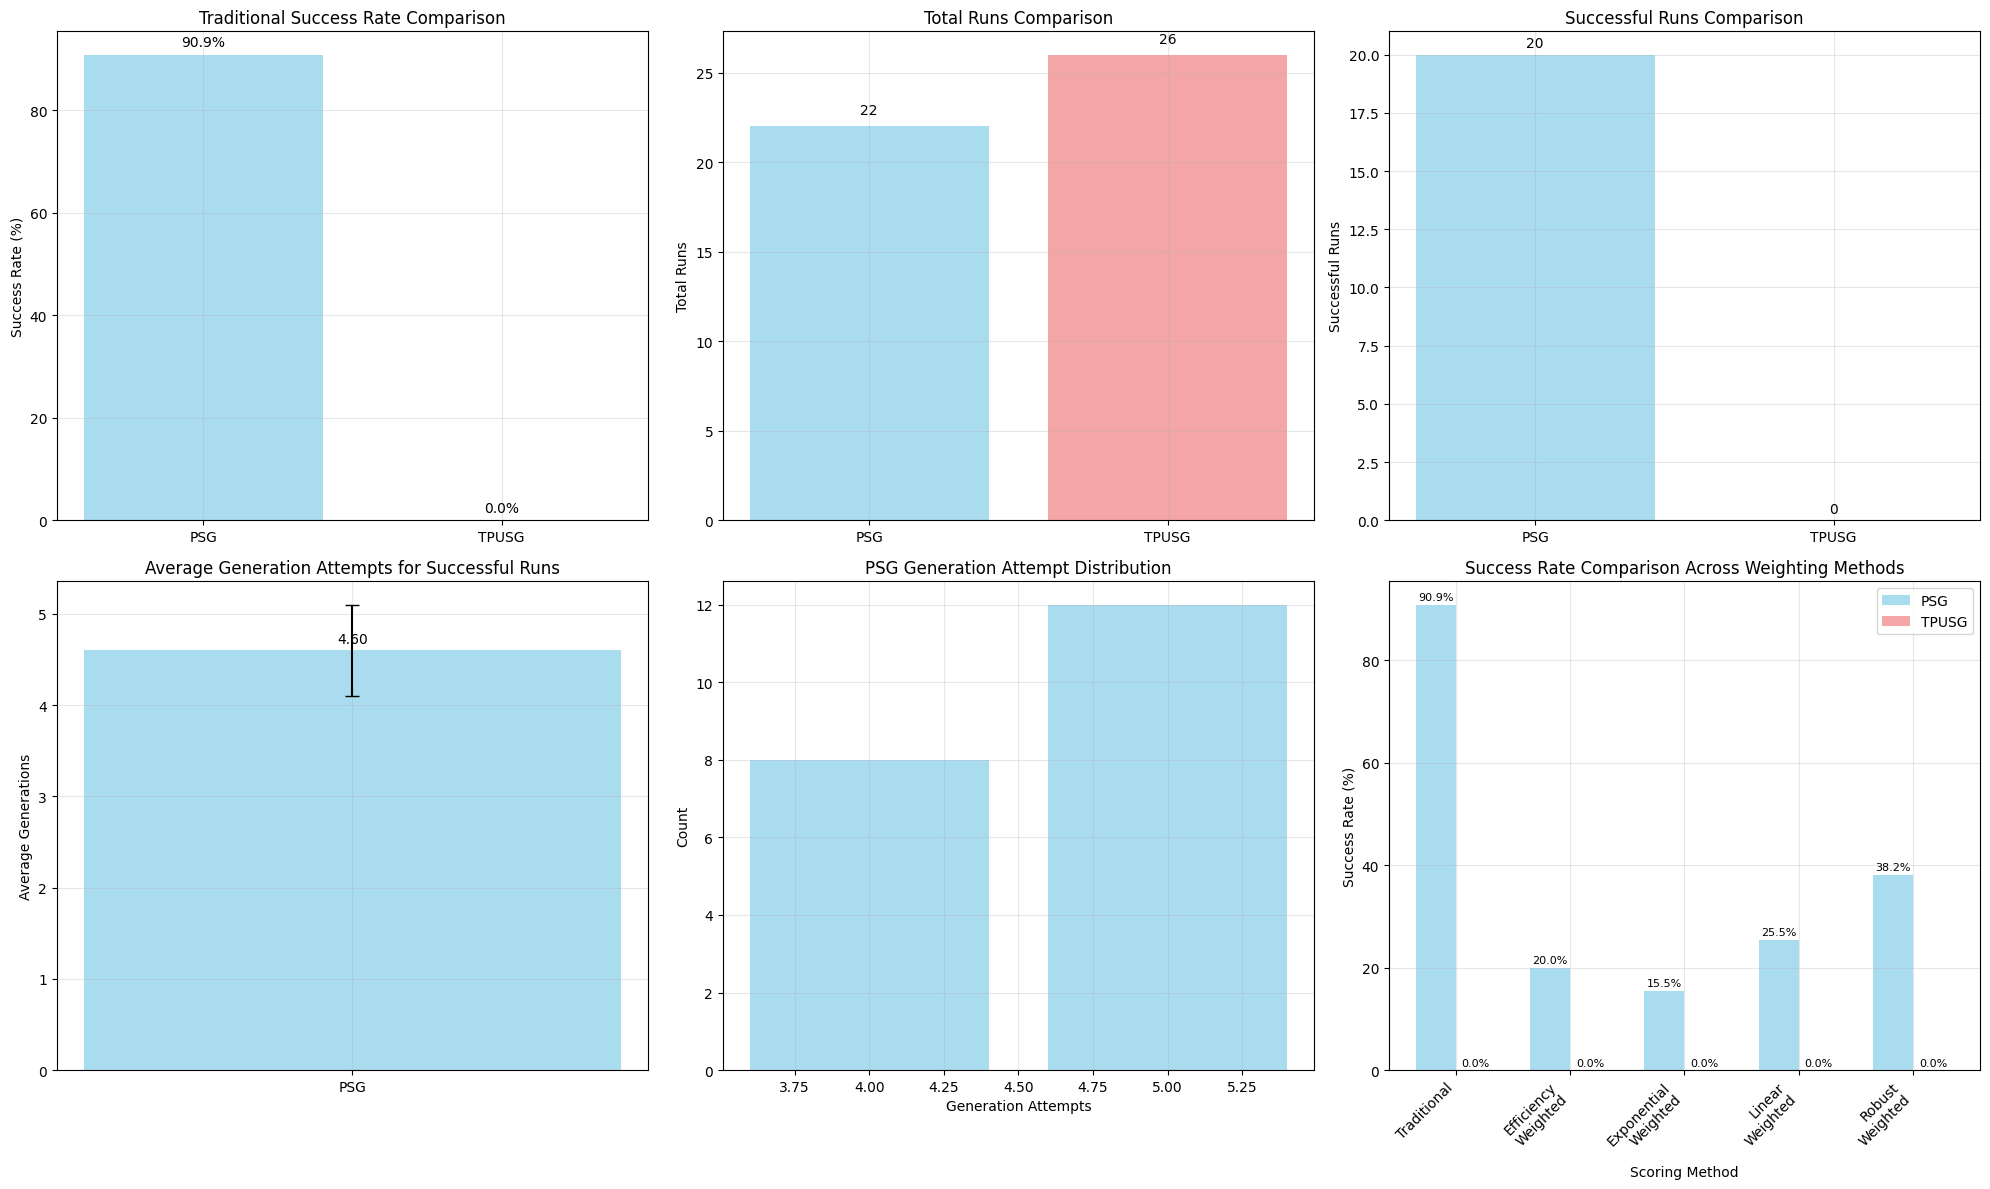


RELATIVE PERFORMANCE ANALYSIS
Traditional         : PSG  90.9% vs TPUSG   0.0% (TPUSG has no successful runs)
Efficiency
Weighted : PSG  20.0% vs TPUSG   0.0% (TPUSG has no successful runs)
Exponential
Weighted: PSG  15.5% vs TPUSG   0.0% (TPUSG has no successful runs)
Linear
Weighted     : PSG  25.5% vs TPUSG   0.0% (TPUSG has no successful runs)
Robust
Weighted     : PSG  38.2% vs TPUSG   0.0% (TPUSG has no successful runs)

Analysis complete. Generated weighted CSV files are saved in: /Users/hann/Projects/reference-benchmark-tinyml_llm/data_analysis/2025/08.12/processed_data


In [79]:
    # Create comprehensive visualization
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20, 12))
    
    # First, let's check what data we have
    print("Available keys in analysis_results:")
    for key, value in analysis_results.items():
        print(f"  {key}: {list(value.keys())}")
    print()
    
    processors = ['PSG', 'TPUSG']
    colors = ['skyblue', 'lightcoral']
    
    # 1. Basic Success Rate Comparison
    success_rates = [analysis_results[p]['traditional_success_rate'] * 100 for p in processors]
    bars = ax1.bar(processors, success_rates, color=colors, alpha=0.7)
    ax1.set_ylabel('Success Rate (%)')
    ax1.set_title('Traditional Success Rate Comparison')
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, rate in zip(bars, success_rates):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{rate:.1f}%', ha='center', va='bottom')
    
    # 2. Total Runs Comparison
    total_runs = [analysis_results[p]['total_runs'] for p in processors]
    bars = ax2.bar(processors, total_runs, color=colors, alpha=0.7)
    ax2.set_ylabel('Total Runs')
    ax2.set_title('Total Runs Comparison')
    ax2.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, runs in zip(bars, total_runs):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{runs}', ha='center', va='bottom')
    
    # 3. Success Count Comparison
    success_counts = [analysis_results[p]['success_count'] for p in processors]
    bars = ax3.bar(processors, success_counts, color=colors, alpha=0.7)
    ax3.set_ylabel('Successful Runs')
    ax3.set_title('Successful Runs Comparison')
    ax3.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, count in zip(bars, success_counts):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, 
                f'{count}', ha='center', va='bottom')
    
    # 4. Average Generations Comparison
    avg_gens = [analysis_results[p]['avg_generations'] for p in processors if analysis_results[p]['success_count'] > 0]
    std_gens = [analysis_results[p]['std_generations'] for p in processors if analysis_results[p]['success_count'] > 0]
    valid_processors = [p for p in processors if analysis_results[p]['success_count'] > 0]
    
    if avg_gens:
        bars = ax4.bar(valid_processors, avg_gens, yerr=std_gens, capsize=5, color=colors[:len(avg_gens)], alpha=0.7)
        ax4.set_ylabel('Average Generations')
        ax4.set_title('Average Generation Attempts for Successful Runs')
        ax4.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, avg in zip(bars, avg_gens):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
                    f'{avg:.2f}', ha='center', va='bottom')
    
    # 5. Generation Distribution for PSG
    if 'PSG' in analysis_results and 'generation_distribution' in analysis_results['PSG']:
        gen_dist = analysis_results['PSG']['generation_distribution']
        if not gen_dist.empty:  # Check if pandas Series is not empty
            gen_counts = list(gen_dist.index)
            gen_values = list(gen_dist.values)
            ax5.bar(gen_counts, gen_values, color='skyblue', alpha=0.7)
            ax5.set_xlabel('Generation Attempts')
            ax5.set_ylabel('Count')
            ax5.set_title('PSG Generation Attempt Distribution')
            ax5.grid(True, alpha=0.3)
        else:
            ax5.text(0.5, 0.5, 'No PSG generation data available', 
                    ha='center', va='center', transform=ax5.transAxes)
            ax5.set_title('PSG Generation Attempt Distribution')
    else:
        ax5.text(0.5, 0.5, 'No PSG generation data available', 
                ha='center', va='center', transform=ax5.transAxes)
        ax5.set_title('PSG Generation Attempt Distribution')
    
    # 6. Weighted Success Rate Comparison
    methods = ['Traditional', 'Efficiency\nWeighted', 'Exponential\nWeighted', 'Linear\nWeighted', 'Robust\nWeighted']
    
    # Get PSG rates - safely handle missing keys
    psg_rates = []
    if 'PSG' in analysis_results:
        psg_data = analysis_results['PSG']
        psg_rates = [
            psg_data.get('traditional_success_rate', 0) * 100,
            psg_data.get('efficiency_weighted_rate', 0) * 100,
            psg_data.get('exponential_weighted_rate', 0) * 100,
            psg_data.get('linear_weighted_rate', 0) * 100,
            psg_data.get('robust_weighted_rate', 0) * 100
        ]
    else:
        psg_rates = [0] * len(methods)
    
    # Get TPUSG rates - safely handle missing keys  
    tpusg_rates = []
    if 'TPUSG' in analysis_results:
        tpusg_data = analysis_results['TPUSG']
        tpusg_rates = [
            tpusg_data.get('traditional_success_rate', 0) * 100,
            tpusg_data.get('efficiency_weighted_rate', 0) * 100,
            tpusg_data.get('exponential_weighted_rate', 0) * 100,
            tpusg_data.get('linear_weighted_rate', 0) * 100,
            tpusg_data.get('robust_weighted_rate', 0) * 100
        ]
    else:
        tpusg_rates = [0] * len(methods)
    
    x = np.arange(len(methods))
    width = 0.35
    
    bars1 = ax6.bar(x - width/2, psg_rates, width, label='PSG', color='skyblue', alpha=0.7)
    bars2 = ax6.bar(x + width/2, tpusg_rates, width, label='TPUSG', color='lightcoral', alpha=0.7)
    
    ax6.set_xlabel('Scoring Method')
    ax6.set_ylabel('Success Rate (%)')
    ax6.set_title('Success Rate Comparison Across Weighting Methods')
    ax6.set_xticks(x)
    ax6.set_xticklabels(methods, rotation=45, ha='right')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax6.text(bar.get_x() + bar.get_width()/2, height + 0.5,
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and display relative performance
    print("\n" + "="*60)
    print("RELATIVE PERFORMANCE ANALYSIS")
    print("="*60)
    
    for i, method in enumerate(methods):
        psg_rate = psg_rates[i]
        tpusg_rate = tpusg_rates[i] 
        
        if tpusg_rate > 0:
            ratio = psg_rate / tpusg_rate
            advantage = "PSG" if ratio > 1 else "TPUSG"
            print(f"{method:20}: PSG {psg_rate:5.1f}% vs TPUSG {tpusg_rate:5.1f}% "
                  f"(Ratio: {ratio:.2f}, {advantage} advantage)")
        else:
            print(f"{method:20}: PSG {psg_rate:5.1f}% vs TPUSG {tpusg_rate:5.1f}% "
                  f"(TPUSG has no successful runs)")
    
    print(f"\nAnalysis complete. Generated weighted CSV files are saved in: {processed_data_dir}")